In [2]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
import importlib

sys.path.append(os.path.abspath(".."))
from core.utils.data_loader import DataLoader
from core.config.pipeline_config import PipelineConfig
from core.utils.region_mapper import RegionMapper

In [3]:
config = PipelineConfig(
    paths={
        "root_dir": "../data",
        "data_dir": "../data/dataset",
        "models_dir": "../models",
        "outputs_dir": "../data/processed",
        "logs_dir": "../logs",
        "configs_dir": "../configs",
        "checkpoints_dir": "../checkpoints"
    }
)

loader = DataLoader(config)
df = loader.load_csv_complete(config.paths.data_dir / "names_featured.csv")
shapefile_path = "../data/dataset/osm_rdc_11provinces_210611/OSM_RDC_11provinces_210611.shp"
gdf = gpd.read_file(shapefile_path)

## Breakdown by major province

In [20]:
# Harmonise province names in the GeoDataFrame
mapper = RegionMapper()
df['province_old'] = mapper.map(df['region'])
df['province_clean'] = df['province_old'].str.upper().str.strip() \
    .str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')
gdf['province_upper'] = gdf['name'].str.upper().str.strip() \
    .str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')
counts = df.groupby('province_clean').size().reset_index(name='count')
gdf_merged = gdf.merge(counts, left_on='province_upper', right_on='province_clean', how='left')

In [22]:
print(gdf_merged[['province_upper', 'count']])

      province_upper    count
0           KINSHASA  1122741
1          BAS-CONGO   268080
2           SUD-KIVU   345919
3          NORD-KIVU   394744
4            MANIEMA   127800
5   KASAI-OCCIDENTAL   362755
6     KASAI-ORIENTAL   358061
7           EQUATEUR   356387
8          ORIENTALE   317180
9           BANDUNDU   809915
10           KATANGA   835905


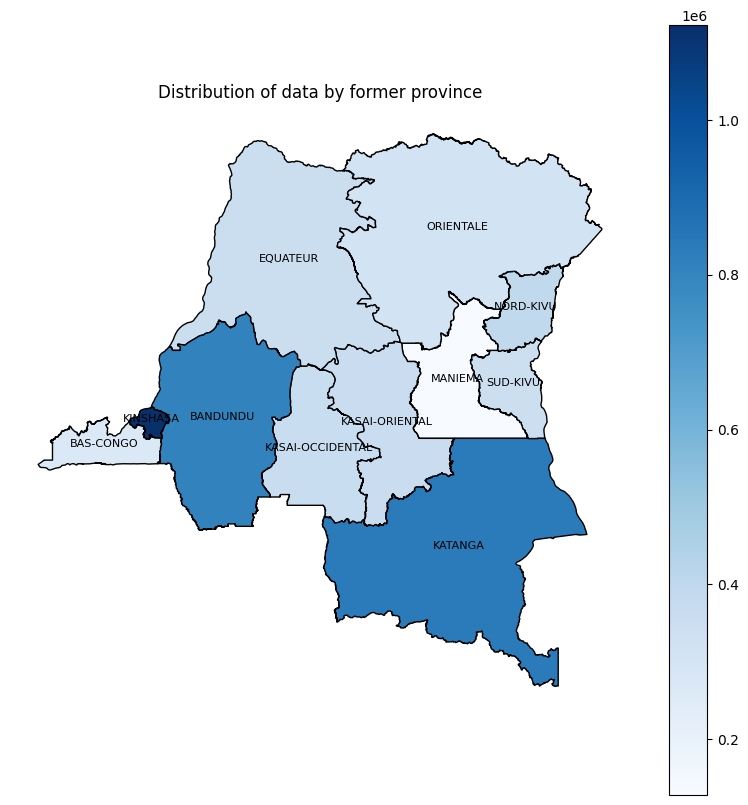

In [24]:
# Distribution of data by former province
fig, ax = plt.subplots(figsize=(10, 10))
gdf_merged.plot(column='count', cmap='Blues', edgecolor='black', legend=True, ax=ax)
for idx, row in gdf_merged.iterrows():
    if pd.notna(row['count']):
        centroid = row['geometry'].centroid
        plt.text(centroid.x, centroid.y, row['province_upper'], 
                 horizontalalignment='center', fontsize=8, color='black')

plt.title('Distribution of data by former province')
plt.axis('off')
plt.show()

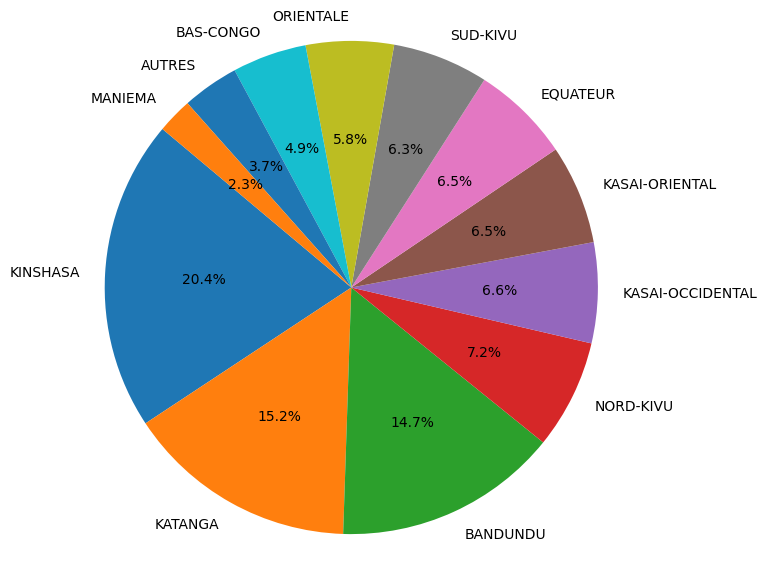

In [25]:
provinces = df['province'].value_counts()
plt.figure(figsize=(7, 7))
plt.pie(provinces, labels=provinces.index, autopct='%1.1f%%', startangle=140)
plt.axis('equal')
plt.show()

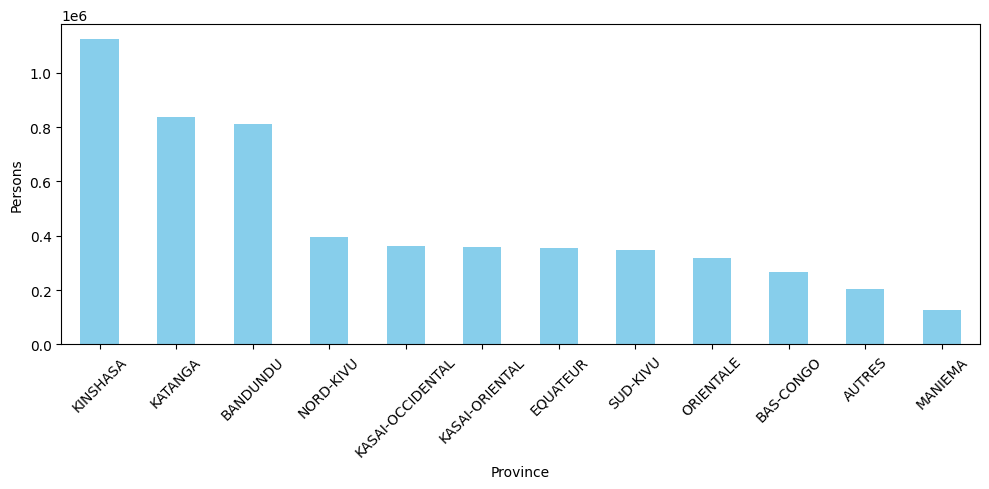

In [26]:
plt.figure(figsize=(10, 5))
provinces.plot(kind='bar', color='skyblue')
plt.xlabel("Province")
plt.ylabel("Persons")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [27]:
#breakdown of names into surname, middle name and first name
#retrieve all rows whose name is identified as simple, and delete rows whose identified_name is null or empty

df_simple = df[df['identified_category'] == 'simple'].copy()
df_simple['surname'] = df_simple['identified_name'].str.split().str[0]
df_simple['middle_name'] = df_simple['identified_name'].str.split().str[1]
df_simple['first_name'] = df_simple['identified_surname']
df_simple = df_simple[df_simple['first_name'].notna() & (df_simple['first_name'].str.strip() != '')]

df_simple[['name', 'surname', 'middle_name', 'first_name']].head()

,name,surname,middle_name,first_name
0,DIKOKO PAMITSHEFU FABRICE,DIKOKO,PAMITSHEFU,FABRICE
1,EPENGE DJONGESONGO JONAS,EPENGE,DJONGESONGO,JONAS
2,EYONGOYONGO SHAKO MICHEL,EYONGOYONGO,SHAKO,MICHEL
3,KASSONGO OSANGO ISRAEL,KASSONGO,OSANGO,ISRAEL
4,OKAWONGA ONGONDJO ALPHONSE,OKAWONGA,ONGONDJO,ALPHONSE


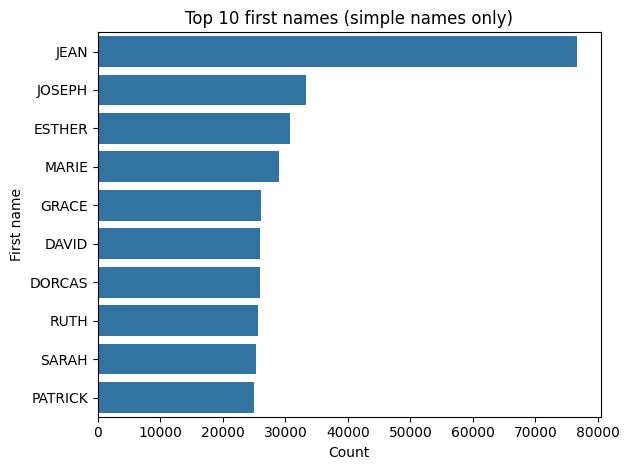

In [28]:
# Simple distribution of first names (display of the 10 most popular first names)
sns.countplot(y=df_simple['first_name'], order=df_simple['first_name'].value_counts().iloc[:10].index)
plt.title("Top 10 first names (simple names only)")
plt.xlabel("Count")
plt.ylabel("First name")
plt.tight_layout()
plt.show()

In [29]:
firstnames = df_simple['first_name'].value_counts()
df_firstnames = firstnames.reset_index()
df_firstnames.columns = ['First name', 'quantity']
df_firstnames.head(10)

,First name,quantity
0,JEAN,76636
1,JOSEPH,33263
2,ESTHER,30688
3,MARIE,29049
4,GRACE,26028
5,DAVID,26012
6,DORCAS,25950
7,RUTH,25688
8,SARAH,25225
9,PATRICK,25057


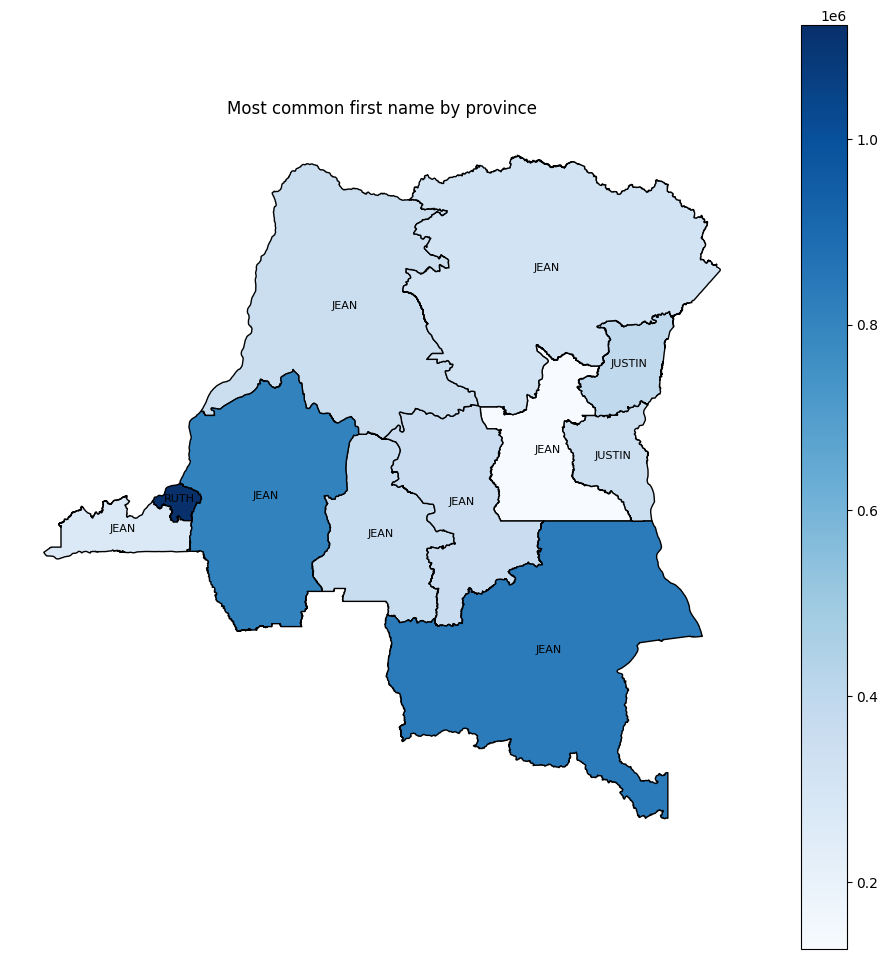

In [30]:
#Most common first name by province
top_names = df_simple.groupby(['province_clean', 'first_name']).size().reset_index(name='count')
top_names = top_names.sort_values(['province_clean', 'count'], ascending=[True, False])
top_names = top_names.drop_duplicates(subset='province_clean', keep='first')
gdf_named = gdf_merged.merge(top_names[['province_clean', 'first_name']], 
                             left_on='province_upper', right_on='province_clean', 
                             how='left')

fig, ax = plt.subplots(figsize=(12, 12))
gdf_named.plot(column='count', cmap='Blues', edgecolor='black', legend=True, ax=ax)

for idx, row in gdf_named.iterrows():
    if pd.notna(row['first_name']):
        centroid = row['geometry'].centroid
        label = f"{row['first_name']}"
        plt.text(centroid.x, centroid.y, label, 
                 horizontalalignment='center', fontsize=8, color='black')

plt.title("Most common first name by province")
plt.axis('off')
plt.show()

In [31]:
# Top 5 first names by province
top5_names = (
    df_simple.groupby(['province_clean', 'first_name'])
    .size()
    .reset_index(name='count')
    .sort_values(['province_clean', 'count'], ascending=[True, False])
    .groupby('province_clean', group_keys=False)
    .head(5)
)
def make_row(group):
    return pd.Series(
        {f'Name {i+1}': f"{row.first_name} ({row.count})"
         for i, row in enumerate(group.itertuples())}
    )

table = top5_names.groupby('province_clean', group_keys=False).apply(make_row, include_groups=False).reset_index()
print(table)

      province_clean         Name 1            Name 2          Name 3  \
0             AUTRES    JEAN (5430)     JOSEPH (2427)    ANDRE (1817)   
1           BANDUNDU    JEAN (6150)       JOEL (1982)    MARIE (1471)   
2          BAS-CONGO    JEAN (4118)     JOSEPH (2604)    MARIE (2239)   
3           EQUATEUR   JEAN (10240)     JOSEPH (3870)    MARIE (2917)   
4   KASAI-OCCIDENTAL   JEAN (12563)      ANDRE (5843)    MARIE (4385)   
5     KASAI-ORIENTAL   JEAN (13801)      MARIE (5039)   JOSEPH (4998)   
6            KATANGA    JEAN (9415)    PATRICK (5192)  PATIENT (4826)   
7           KINSHASA   RUTH (12283)    DORCAS (12255)   SARAH (12109)   
8            MANIEMA    JEAN (1505)      JOSEPH (799)     MARIE (668)   
9          NORD-KIVU  JUSTIN (4131)      GRACE (3712)    MOISE (3451)   
10         ORIENTALE    JEAN (5402)     JOSEPH (3416)    MOISE (3126)   
11          SUD-KIVU  JUSTIN (2742)  CHRISTIAN (2318)     JEAN (2203)   

              Name 4           Name 5  
0      PIE

In [32]:
# Rare firstnames per province (based on TF-IDF, low = rare)
first_name_counts = df_simple.groupby(['province_clean', 'first_name'], observed=False).size().reset_index(name='count')

province_totals = first_name_counts.groupby('province_clean', observed=False)['count'].transform('sum')
first_name_counts['tf'] = first_name_counts['count'] / province_totals

province_per_firstname = first_name_counts.groupby('first_name', observed=False)['province_clean'].nunique()
first_name_counts = first_name_counts.merge(province_per_firstname.rename('df'), on='first_name')

N = first_name_counts['province_clean'].nunique()
first_name_counts['idf'] = np.log((N + 1) / (first_name_counts['df'] + 1)) + 1

first_name_counts['tfidf'] = first_name_counts['tf'] * first_name_counts['idf']

top_rare_firstnames = first_name_counts.sort_values(['province_clean', 'tfidf'], ascending=[True, True]) \
                                  .groupby('province_clean', observed=False).head(1)

print("Most rare first name per province based on TF-IDF:")
print(top_rare_firstnames[['province_clean', 'first_name', 'count', 'tfidf']].sort_values(['province_clean']))

Most rare first name per province based on TF-IDF:
          province_clean first_name  count         tfidf
158               AUTRES     ADELAR      1  5.811555e-06
19300           BANDUNDU   ABDALLAH      1  3.312695e-06
70172          BAS-CONGO  ABOUBACAR      1  4.117022e-06
98788           EQUATEUR      AGATH      1  3.205118e-06
128132  KASAI-OCCIDENTAL   ADELAIDE      1  3.741577e-06
142452    KASAI-ORIENTAL  ABOUBACAR      1  3.029982e-06
164336           KATANGA       BERN      1  1.460884e-06
218742          KINSHASA      ALBER      1  9.659792e-07
305254           MANIEMA          A      1  1.453256e-05
319234         NORD-KIVU   ABDOULAY      1  2.876258e-06
350969         ORIENTALE   ADELAIDE      1  3.742991e-06
372099          SUD-KIVU     ADELAR      1  4.896680e-06


In [33]:
# Total number of distinct first names
total_firstnames = df_simple['first_name'].nunique()
print(f">> Total number of first names registered : {total_firstnames}")

# Categorization of first names
firstnames_by_sex = df_simple.groupby(['first_name', 'sex'], observed=False).size().unstack(fill_value=0)
male_firstnames = firstnames_by_sex[(firstnames_by_sex['m'] > 0) & (firstnames_by_sex['f'] == 0)]
print(f">> Number of all-male first names : {len(male_firstnames)}")
female_firstnames = firstnames_by_sex[(firstnames_by_sex['f'] > 0) & (firstnames_by_sex['m'] == 0)]
print(f">> Number of all-female first names : {len(female_firstnames)}")
neutral_firstnames = firstnames_by_sex[(firstnames_by_sex['m'] > 0) & (firstnames_by_sex['f'] > 0)]
print(f">> Number of all-neutral first names : {len(neutral_firstnames)}")

>> Total number of first names registered : 230964
>> Number of all-male first names : 128518
>> Number of all-female first names : 70733
>> Number of all-neutral first names : 31713


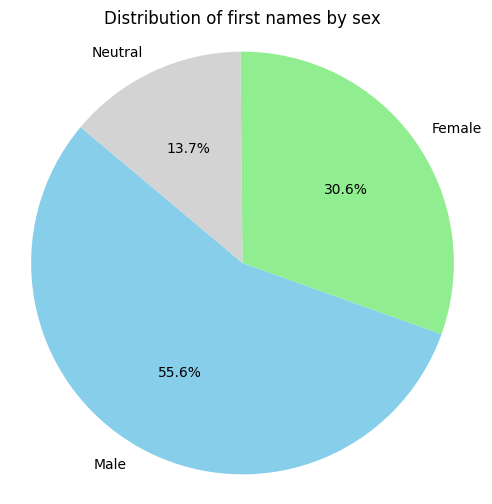

In [34]:
# data for graphic interpretation 
labels = ['Male', 'Female', 'Neutral']
values = [len(male_firstnames), len(female_firstnames), len(neutral_firstnames)]

# circular
plt.figure(figsize=(6,6))
plt.pie(values, labels=labels, autopct='%1.1f%%', startangle=140, colors=['skyblue', 'lightgreen', 'lightgray'])
plt.title("Distribution of first names by sex")
plt.axis('equal')
plt.show()

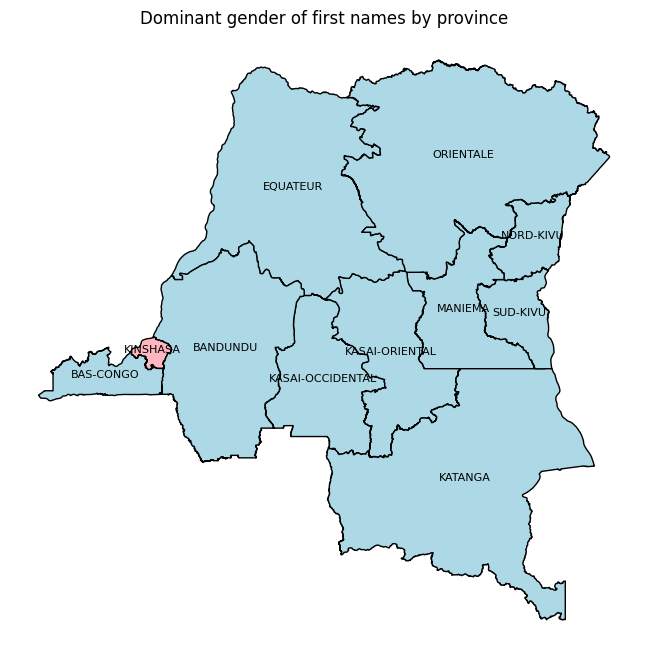

In [35]:
#Dominant gender of first names by province
# light pink if is female, and lightblue if is male
df_counts = (
    df_simple.dropna(subset=['first_name', 'sex'])
    .groupby(['province_clean', 'sex'], observed=False)
    .size()
    .unstack(fill_value=0)
)

df_counts['dominant'] = df_counts.apply(lambda row: 'Female' if row.get('f', 0) > row.get('m', 0) else 'Male', axis=1)
map_df = gdf.set_index('province_upper').join(df_counts['dominant'], how='inner')
color_map = {'Male': 'lightblue', 'Female': 'lightpink'}
map_df['color'] = map_df['dominant'].map(color_map)

fig, ax = plt.subplots(figsize=(10, 8))
map_df.plot(color=map_df['color'], edgecolor='black', ax=ax)
for idx, row in map_df.iterrows():
    plt.annotate(text=row.name, xy=(row.geometry.centroid.x, row.geometry.centroid.y),
                 horizontalalignment='center', fontsize=8, color='black')

plt.title("Dominant gender of first names by province")
plt.axis('off')
plt.show()

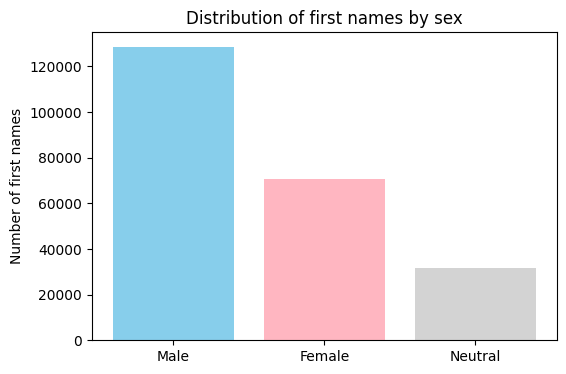

In [36]:
# Histogram
plt.figure(figsize=(6,4))
plt.bar(labels, values, color=['skyblue', 'lightpink', 'lightgray'])
plt.title("Distribution of first names by sex")
plt.ylabel("Number of first names")
plt.show()

In [37]:
# Count of unique first names per region (province)
distinct_regions = df_simple['province'].nunique()
print(f">> Number of distinct regions: {distinct_regions}")
firstnames_by_region = df_simple.groupby('province')['first_name'].nunique().sort_values(ascending=False)

print("Number of unique first names per region")
df_firstnames_region = firstnames_by_region.reset_index()
df_firstnames_region.columns = ['Region', 'Unique first names']
df_firstnames_region.head(12)


>> Number of distinct regions: 12
Number of unique first names per region


,Region,Unique first names
0,KINSHASA,88263
1,KATANGA,58298
2,BANDUNDU,50782
3,NORD-KIVU,31569
4,EQUATEUR,29670
5,BAS-CONGO,28274
6,SUD-KIVU,27631
7,ORIENTALE,21133
8,AUTRES,19255
9,KASAI-ORIENTAL,16323


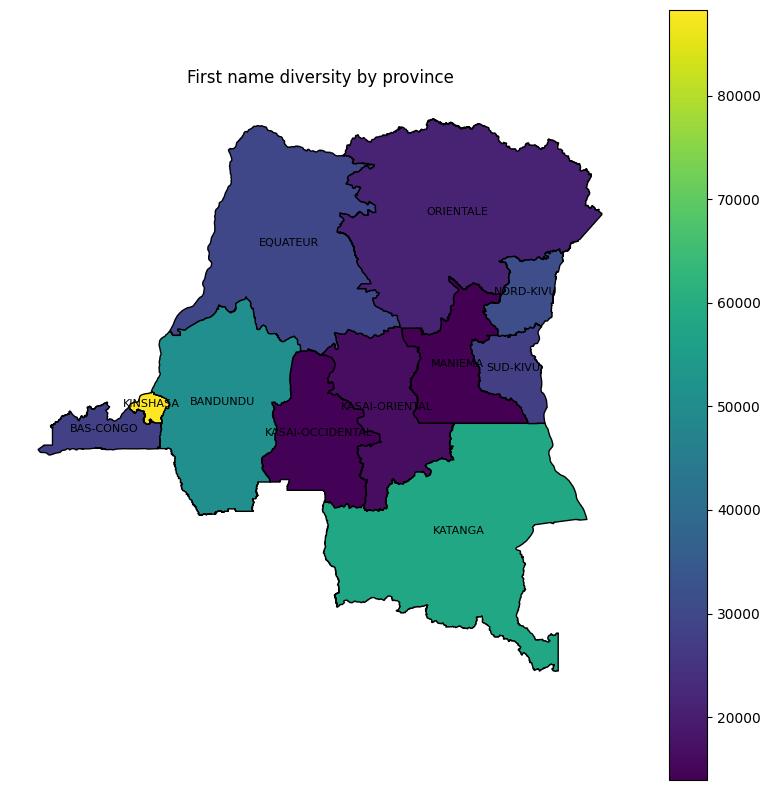

In [38]:
unique_first_names = df_simple.groupby('province')['first_name'].nunique().reset_index(name='unique_count')
unique_first_names['province_clean'] = unique_first_names['province'].str.upper().str.strip() \
    .str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')
gdf_diversity = gdf_merged.merge(unique_first_names[['province_clean', 'unique_count']], on='province_clean', how='left')

fig, ax = plt.subplots(figsize=(10, 10))
gdf_diversity.plot(column='unique_count', cmap='viridis', edgecolor='black', legend=True, ax=ax)

for idx, row in gdf_diversity.iterrows():
    centroid = row['geometry'].centroid
    plt.text(centroid.x, centroid.y, row['province_upper'], 
             horizontalalignment='center', fontsize=8, color='black')

plt.title("First name diversity by province")
plt.axis('off')
plt.show()

In [39]:
# top 3 most popular first names by region
grouped = df_simple.groupby(['province', 'first_name']).size().reset_index(name='count')
grouped = grouped.sort_values(['province', 'count'], ascending=[True, False])
top3_by_region = grouped.groupby('province').head(3)

for province, group in top3_by_region.groupby('province'):
    print(f"{province.upper()}")
    for _, row in group.iterrows():
        print(f"    {row['first_name']:<15} {row['count']}")
    print()

AUTRES
    JEAN            5430
    JOSEPH          2427
    ANDRE           1817

BANDUNDU
    JEAN            6150
    JOEL            1982
    MARIE           1471

BAS-CONGO
    JEAN            4118
    JOSEPH          2604
    MARIE           2239

EQUATEUR
    JEAN            10240
    JOSEPH          3870
    MARIE           2917

KASAI-OCCIDENTAL
    JEAN            12563
    ANDRE           5843
    MARIE           4385

KASAI-ORIENTAL
    JEAN            13801
    MARIE           5039
    JOSEPH          4998

KATANGA
    JEAN            9415
    PATRICK         5192
    PATIENT         4826

KINSHASA
    RUTH            12283
    DORCAS          12255
    SARAH           12109

MANIEMA
    JEAN            1505
    JOSEPH          799
    MARIE           668

NORD-KIVU
    JUSTIN          4131
    GRACE           3712
    MOISE           3451

ORIENTALE
    JEAN            5402
    JOSEPH          3416
    MOISE           3126

SUD-KIVU
    JUSTIN          2742
    CHRISTIAN 

In [40]:
#Group by region, gender and first name, then count
def determine_sex_category(row):
    if row['first_name'] in neutral_firstnames:
        return 'Neutral'
    return row['sex']

df_simple['sex_category'] = df_simple.apply(determine_sex_category, axis=1)

# Groupement
grouped = df_simple.groupby(['province', 'sex_category', 'first_name']).size().reset_index(name='count')
grouped = grouped.sort_values(['province', 'sex_category', 'count'], ascending=[True, True, False])
top3_by_region_sex = grouped.groupby(['province', 'sex_category']).head(3)

for (province, sex), group in top3_by_region_sex.groupby(['province', 'sex_category']):
    print(f"{province.upper()} - {sex}")
    for _, row in group.iterrows():
        print(f"    {row['first_name']:<15} {row['count']}")
    print()

AUTRES - f
    MARIE           1523
    THERESE         811
    ESTHER          741

AUTRES - m
    JEAN            5425
    JOSEPH          2424
    ANDRE           1812

BANDUNDU - f
    MARIE           1423
    ESTHER          1323
    RUTH            1302

BANDUNDU - m
    JEAN            6113
    JOEL            1928
    DIEU            1386

BAS-CONGO - f
    MARIE           2222
    DORCAS          1694
    ESTHER          1451

BAS-CONGO - m
    JEAN            4104
    JOSEPH          2593
    ANDRE           1443

EQUATEUR - f
    MARIE           2864
    ESTHER          2309
    RUTH            1692

EQUATEUR - m
    JEAN            10196
    JOSEPH          3855
    JEREMIE         2780

KASAI-OCCIDENTAL - f
    MARIE           4296
    THERESE         1987
    ESTHER          1797

KASAI-OCCIDENTAL - m
    JEAN            12542
    ANDRE           5836
    FRANCOIS        4103

KASAI-ORIENTAL - f
    MARIE           4972
    THERESE         2599
    RACHEL          1792

K

In [41]:
# Grouping surnames by sex
surnames_by_sex = (df_simple.groupby(['surname', 'sex'], observed=False).size().reset_index(name='count'))
surnames_by_sex = surnames_by_sex.sort_values(['sex', 'count'], ascending=[True, False])
top10_per_sex = surnames_by_sex.groupby('sex', observed=False).head(10)

for sex, group in top10_per_sex.groupby('sex', observed=False):
    print(f"Top 10 surnames for sex: {sex}")
    for _, row in group.iterrows():
        print(f"    {row['surname']:<15} {row['count']}")
    print()

Top 10 surnames for sex: f
    KAVIRA          22849
    KAVUGHO         13590
    KAHINDO         13539
    NTUMBA          11473
    ILUNGA          10730
    MBUYI           10539
    NGALULA         10480
    MASIKA          10292
    MUJINGA         10042
    KAPINGA         9858

Top 10 surnames for sex: m
    ILUNGA          30113
    KAMBALE         23136
    NGOY            20530
    KASONGO         20200
    KASEREKA        16007
    MUHINDO         14349
    KAZADI          12035
    MUTOMBO         11473
    KAKULE          11426
    MUMBERE         11115



In [42]:
# Grouping surnames by region
surnames_by_region = df_simple.groupby(['province', 'surname']).size().reset_index(name='count')
surnames_by_region = surnames_by_region.sort_values(['province', 'count'], ascending=[True, False])
top3_surnames_per_region = surnames_by_region.groupby('province').head(3)

for province, group in top3_surnames_per_region.groupby('province'):
    print(f"{province.upper()}")
    for _, row in group.iterrows():
        print(f"    {row['surname']:<15} {row['count']}")
    print()

AUTRES
    NGOYI           1956
    ILUNGA          1621
    MBUYI           1318

BANDUNDU
    MBO             4336
    MPIA            3030
    MPUTU           2248

BAS-CONGO
    NZUZI           4758
    NLANDU          4071
    MATONDO         3492

EQUATEUR
    MBOYO           2110
    LOKULI          1123
    BOLUMBU         1014

KASAI-OCCIDENTAL
    NTUMBA          6025
    MBUYI           5021
    KANKU           3430

KASAI-ORIENTAL
    NGOYI           7942
    ILUNGA          5241
    MBUYI           4932

KATANGA
    ILUNGA          27775
    NGOY            23185
    KASONGO         16894

KINSHASA
    NTUMBA          5984
    NSIMBA          5625
    MATONDO         5355

MANIEMA
    AMISI           1194
    RAMAZANI        1016
    ASSANI          757

NORD-KIVU
    KAMBALE         21332
    KAVIRA          21194
    KASEREKA        14883

ORIENTALE
    BAHATI          1328
    KAMBALE         1067
    BARAKA          1048

SUD-KIVU
    BAHATI          2886
    FURAHA   

In [43]:
# Grouping surnames by region and sex
grouped = df_simple.groupby(['province', 'sex', 'surname'], observed=False).size().reset_index(name='count')
grouped = grouped.sort_values(['province', 'sex', 'count'], ascending=[True, True, False])
top3_surnames_by_region_sex = grouped.groupby(['province', 'sex'], observed=False).head(3)

for (province, sex), group in top3_surnames_by_region_sex.groupby(['province', 'sex'], observed=False):
    print(f"{province.upper()} - {sex}")
    for _, row in group.iterrows():
        print(f"    {row['surname']:<15} {row['count']}")
    print()

AUTRES - f
    NTUMBA          580
    KAPINGA         567
    MBUYI           545

AUTRES - m
    NGOYI           1622
    ILUNGA          1438
    KASONGO         1120

BANDUNDU - f
    MBO             1507
    MPIA            1103
    MPUTU           832

BANDUNDU - m
    MBO             2829
    MPIA            1927
    MPUTU           1416

BAS-CONGO - f
    NZUZI           2543
    NLANDU          1873
    TSIMBA          1805

BAS-CONGO - m
    NZUZI           2215
    NLANDU          2198
    NGOMA           2033

EQUATEUR - f
    MBOYO           983
    BOLUMBU         775
    AMBA            576

EQUATEUR - m
    MBOYO           1127
    LOKULI          891
    LOKWA           584

KASAI-OCCIDENTAL - f
    NGALULA         3263
    KAPINGA         1933
    NTUMBA          1881

KASAI-OCCIDENTAL - m
    NTUMBA          4144
    NGALAMULUME     3331
    MBUYI           3221

KASAI-ORIENTAL - f
    NTUMBA          2159
    MBUYI           2156
    NGOYI           1855

KASAI-ORIE

In [44]:
# Find surnames common to both sexes per region - the most popular per region
common_surnames = df_simple.groupby(['province', 'surname', 'sex'], observed=False).size().unstack(fill_value=0)
common_surnames = common_surnames[(common_surnames.get('m', 0) > 0) & (common_surnames.get('f', 0) > 0)]
common_surnames['total'] = common_surnames['m'] + common_surnames['f']
common_surnames = common_surnames.reset_index()
top_common_surnames = common_surnames.sort_values(['province', 'total'], ascending=[True, False])
top_common_surnames = top_common_surnames.groupby('province', observed=False).first().reset_index()

for _, row in top_common_surnames.iterrows():
    print(f"{row['province'].upper()} → {row['surname']} ({row['m']} M / {row['f']} F) - Total: {row['total']}")


AUTRES → NGOYI (1622 M / 334 F) - Total: 1956
BANDUNDU → MBO (2829 M / 1507 F) - Total: 4336
BAS-CONGO → NZUZI (2215 M / 2543 F) - Total: 4758
EQUATEUR → MBOYO (1127 M / 983 F) - Total: 2110
KASAI-OCCIDENTAL → NTUMBA (4144 M / 1881 F) - Total: 6025
KASAI-ORIENTAL → NGOYI (6087 M / 1855 F) - Total: 7942
KATANGA → ILUNGA (19138 M / 8637 F) - Total: 27775
KINSHASA → NTUMBA (1898 M / 4086 F) - Total: 5984
MANIEMA → AMISI (1022 M / 172 F) - Total: 1194
NORD-KIVU → KAMBALE (21281 M / 51 F) - Total: 21332
ORIENTALE → BAHATI (1053 M / 275 F) - Total: 1328
SUD-KIVU → BAHATI (2145 M / 741 F) - Total: 2886


In [45]:
# Grouping middle names by sex
middlenames_by_sex = df_simple.groupby(['middle_name', 'sex'], observed=False).size().reset_index(name='count')
middlenames_by_sex = middlenames_by_sex.sort_values(['sex', 'count'], ascending=[True, False])
top10_middlenames_per_sex = middlenames_by_sex.groupby('sex', observed=False).head(10)

for sex, group in top10_middlenames_per_sex.groupby('sex', observed=False):
    print(f"Top 10 middle names for sex: {sex}")
    for _, row in group.iterrows():
        print(f"    {row['middle_name']:<15} {row['count']}")
    print()

Top 10 middle names for sex: f
    ILUNGA          11006
    KASONGO         8246
    KAZADI          6610
    NGOY            6410
    NTUMBA          6203
    MUTOMBO         5951
    KABEYA          4689
    MUKENDI         4631
    MATONDO         4526
    NGOYI           4428

Top 10 middle names for sex: m
    ILUNGA          18664
    KASONGO         14130
    NGOY            13164
    MUTOMBO         11067
    KAZADI          10960
    NTUMBA          9184
    NGOYI           8986
    KABEYA          7990
    MUKENDI         7903
    KALALA          7742



In [46]:
# Grouping middle names by region
middlenames_by_region = df_simple.groupby(['province', 'middle_name'], observed=False).size().reset_index(name='count')
middlenames_by_region = middlenames_by_region.sort_values(['province', 'count'], ascending=[True, False])
top3_middlenames_per_region = middlenames_by_region.groupby('province', observed=False).head(3)

for province, group in top3_middlenames_per_region.groupby('province', observed=False):
    print(f"{province.upper()}")
    for _, row in group.iterrows():
        print(f"    {row['middle_name']:<20} {row['count']}")
    print()    

AUTRES
    NGOYI                1909
    ILUNGA               1736
    KASONGO              1387

BANDUNDU
    MOKE                 4024
    MBO                  2048
    MPIA                 1792

BAS-CONGO
    NGOMA                4387
    NLANDU               2588
    KHONDE               2176

EQUATEUR
    MBOYO                1538
    LOKULI               1343
    NKOY                 898

KASAI-OCCIDENTAL
    NTUMBA               5502
    MUAMBA               3463
    NGALAMULUME          2809

KASAI-ORIENTAL
    NGOYI                8403
    ILUNGA               6493
    KAZADI               5415

KATANGA
    ILUNGA               14338
    NGOY                 14279
    KASONGO              10702

KINSHASA
    MATONDO              4935
    NTUMBA               4099
    ILUNGA               3993

MANIEMA
    RAMAZANI             1051
    AMISI                778
    SHABANI              649

NORD-KIVU
    TSONGO               2015
    BAHATI               1533
    MAHAMBA        

In [47]:
# Grouping middle names by province and sex
middlenames_by_province_sex = df_simple.groupby(['province', 'sex', 'middle_name'], observed=False).size().reset_index(name='count')
middlenames_by_province_sex = middlenames_by_province_sex.sort_values(['province', 'sex', 'count'], ascending=[True, True, False])
top3_middlenames_by_province_sex = middlenames_by_province_sex.groupby(['province', 'sex'], observed=False).head(3)

for (province, sex), group in top3_middlenames_by_province_sex.groupby(['province', 'sex'], observed=False):
    print(f"{province.upper()} - {sex}")
    for _, row in group.iterrows():
        print(f"    {row['middle_name']:<20} {row['count']}")
    print()

AUTRES - f
    ILUNGA               484
    NGOYI                466
    KAZADI               370

AUTRES - m
    NGOYI                1443
    ILUNGA               1252
    KASONGO              1045

BANDUNDU - f
    MBO                  852
    MODIRI               751
    MPIA                 741

BANDUNDU - m
    MOKE                 3508
    MBO                  1196
    N                    1118

BAS-CONGO - f
    NGOMA                1952
    NLANDU               1164
    KHONDE               986

BAS-CONGO - m
    NGOMA                2435
    NLANDU               1424
    MUANDA               1218

EQUATEUR - f
    MBOYO                581
    LOKULI               452
    LOKWA                274

EQUATEUR - m
    MBOYO                957
    LOKULI               891
    NKOY                 631

KASAI-OCCIDENTAL - f
    NTUMBA               1387
    MUAMBA               839
    MULUMBA              725

KASAI-OCCIDENTAL - m
    NTUMBA               4115
    MUAMBA            

In [48]:
# Find middle names common to both sexes per region
common_middlenames = df_simple.groupby(['province', 'middle_name', 'sex'], observed=False).size().unstack(fill_value=0)
common_middlenames = common_middlenames[(common_middlenames.get('m', 0) > 0) & (common_middlenames.get('f', 0) > 0)]
common_middlenames['total'] = common_middlenames['m'] + common_middlenames['f']
common_middlenames = common_middlenames.reset_index()
common_middlenames = common_middlenames.sort_values(['province', 'total'], ascending=[True, False])
top3_common_middlenames = common_middlenames.groupby('province', observed=False).head(3)

for province, group in top3_common_middlenames.groupby('province', observed=False):
    print(f"{province.upper()}")
    for _, row in group.iterrows():
        print(f"    {row['middle_name']:<20} {row['total']}")
    print()

AUTRES
    NGOYI                1909
    ILUNGA               1736
    KASONGO              1387

BANDUNDU
    MOKE                 4024
    MBO                  2048
    MPIA                 1792

BAS-CONGO
    NGOMA                4387
    NLANDU               2588
    KHONDE               2176

EQUATEUR
    MBOYO                1538
    LOKULI               1343
    NKOY                 898

KASAI-OCCIDENTAL
    NTUMBA               5502
    MUAMBA               3463
    NGALAMULUME          2809

KASAI-ORIENTAL
    NGOYI                8403
    ILUNGA               6493
    KAZADI               5415

KATANGA
    ILUNGA               14338
    NGOY                 14279
    KASONGO              10702

KINSHASA
    MATONDO              4935
    NTUMBA               4099
    ILUNGA               3993

MANIEMA
    RAMAZANI             1051
    AMISI                778
    SHABANI              649

NORD-KIVU
    TSONGO               2015
    BAHATI               1533
    MAHAMBA        

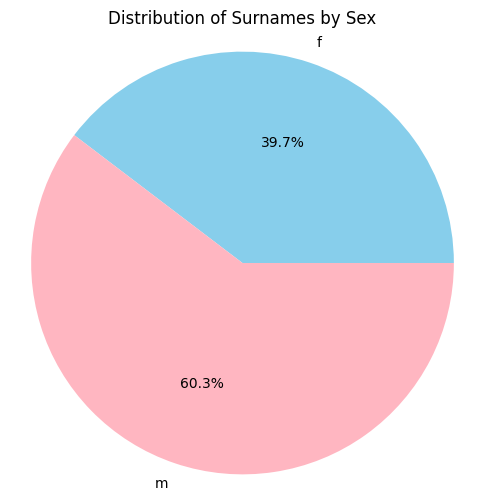

In [49]:
# Pie chart of surnames by sex
surnames_sex_count = surnames_by_sex.groupby('sex', observed=False)['count'].sum()
plt.figure(figsize=(6,6))
plt.pie(surnames_sex_count, labels=surnames_sex_count.index, autopct='%1.1f%%', colors=['skyblue', 'lightpink'])
plt.title("Distribution of Surnames by Sex")
plt.axis('equal')
plt.show()

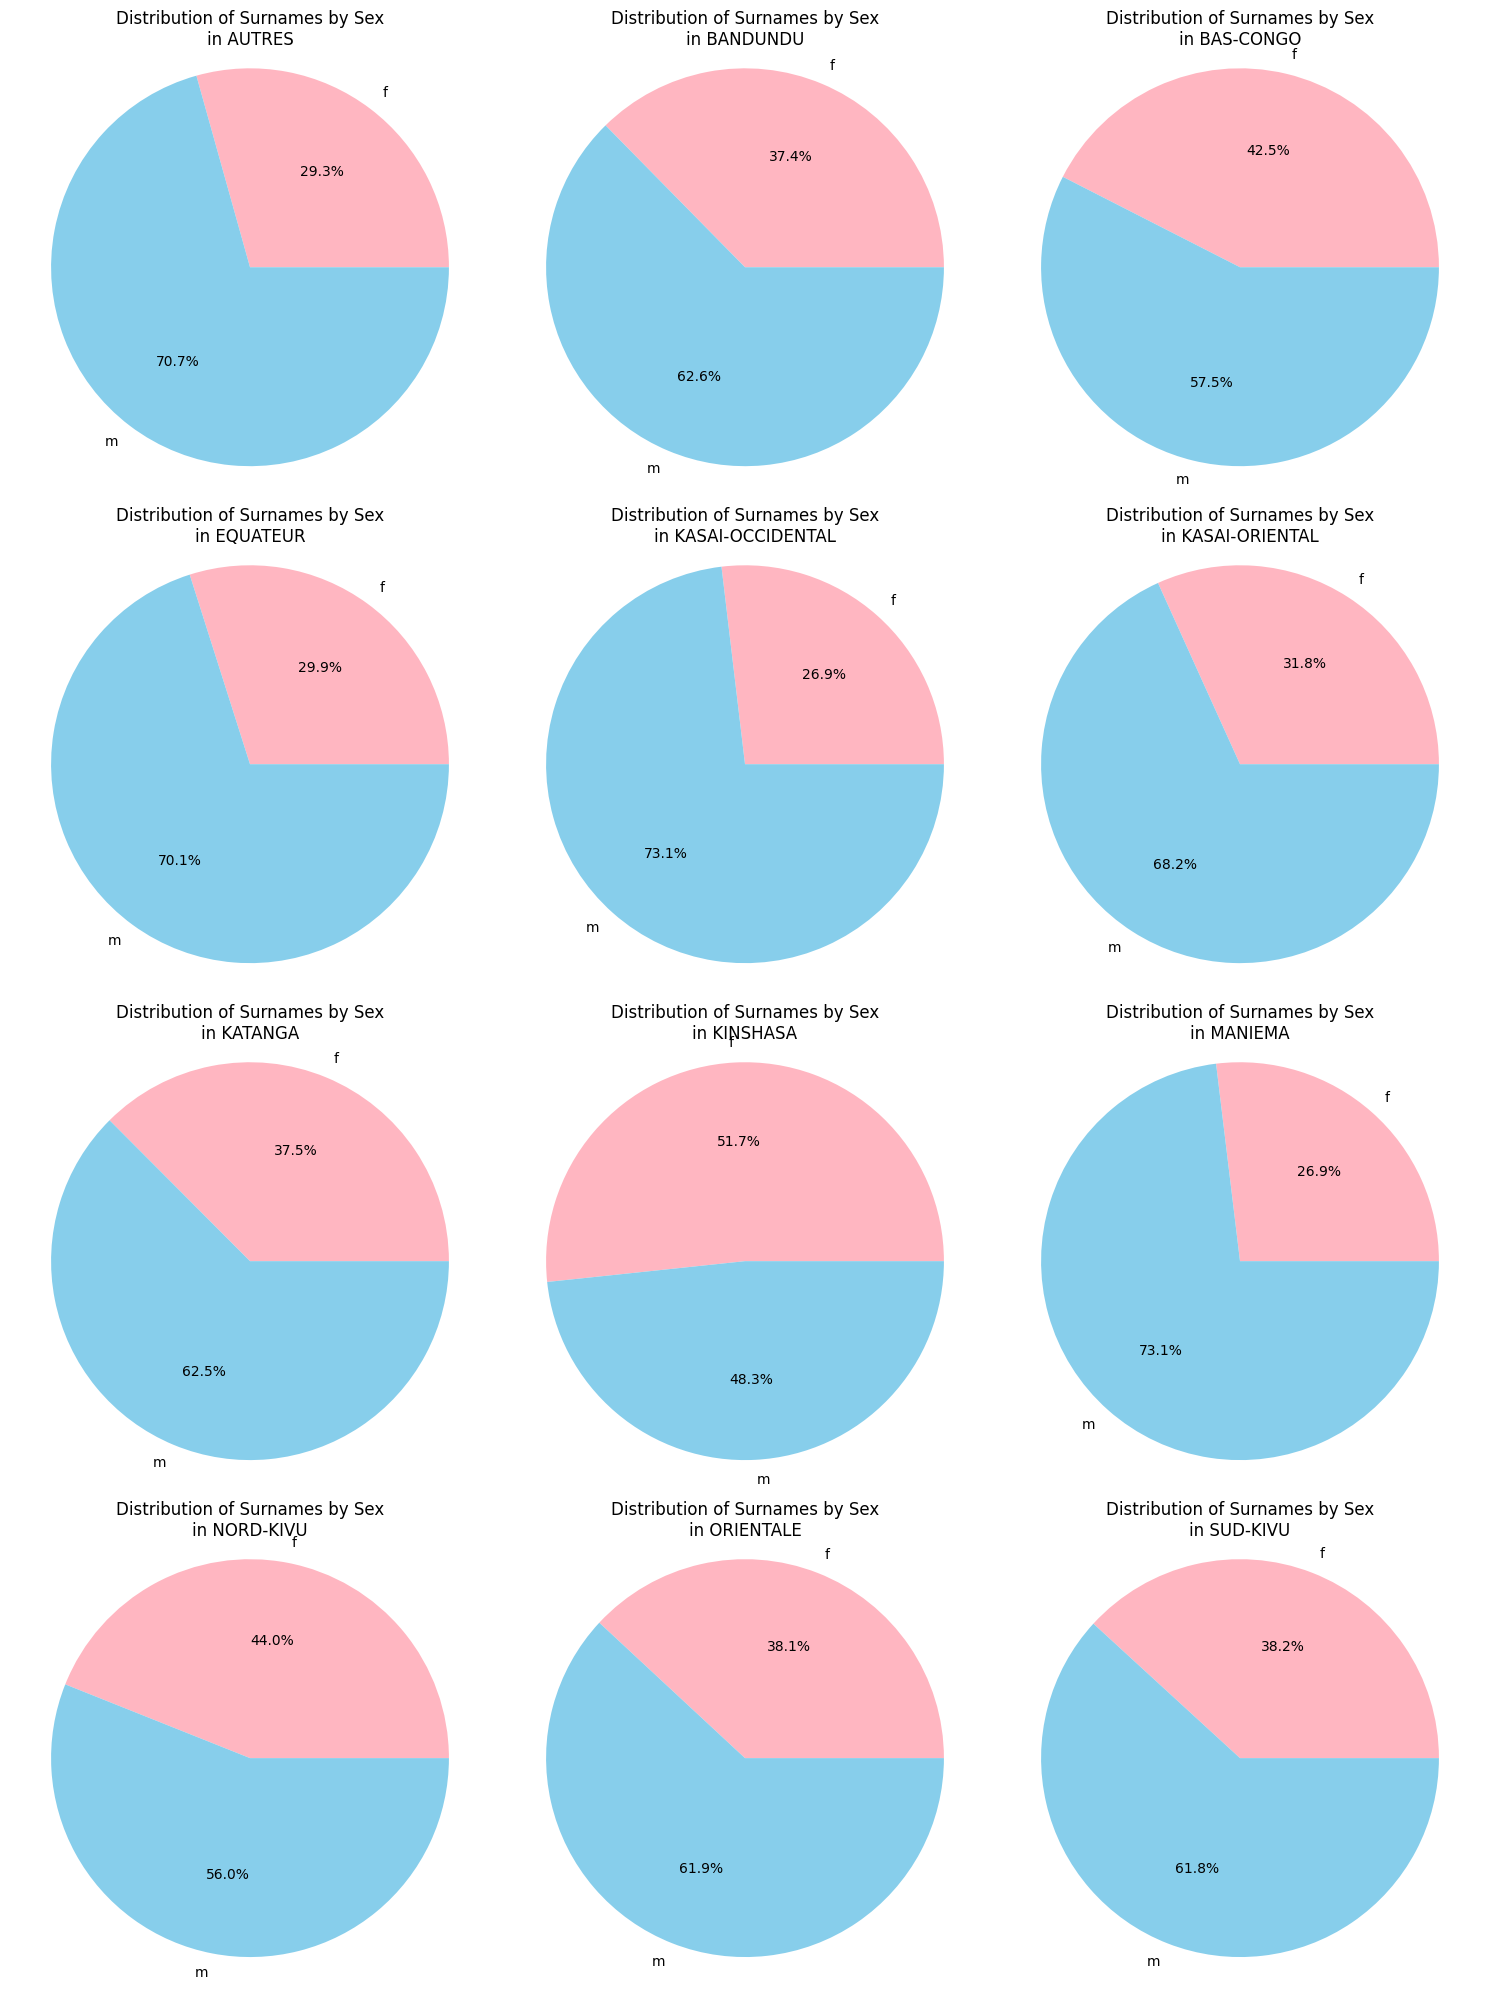

In [50]:
# Pie chart of surnames by sex and region
prov_sex_counts = df_simple.groupby(['province', 'sex'], observed=False).size().reset_index(name='count')
provinces = prov_sex_counts['province'].unique()
cols = 3
rows = (len(provinces) + cols - 1) // cols

plt.figure(figsize=(cols * 5, rows * 5))
for i, prov in enumerate(provinces, 1):
    data = prov_sex_counts[prov_sex_counts['province'] == prov]
    plt.subplot(rows, cols, i)
    plt.pie(data['count'], labels=data['sex'], autopct='%1.1f%%', colors=['lightpink', 'skyblue'])
    plt.title(f"Distribution of Surnames by Sex\nin {prov}")
    plt.axis('equal')

plt.tight_layout()
plt.show()

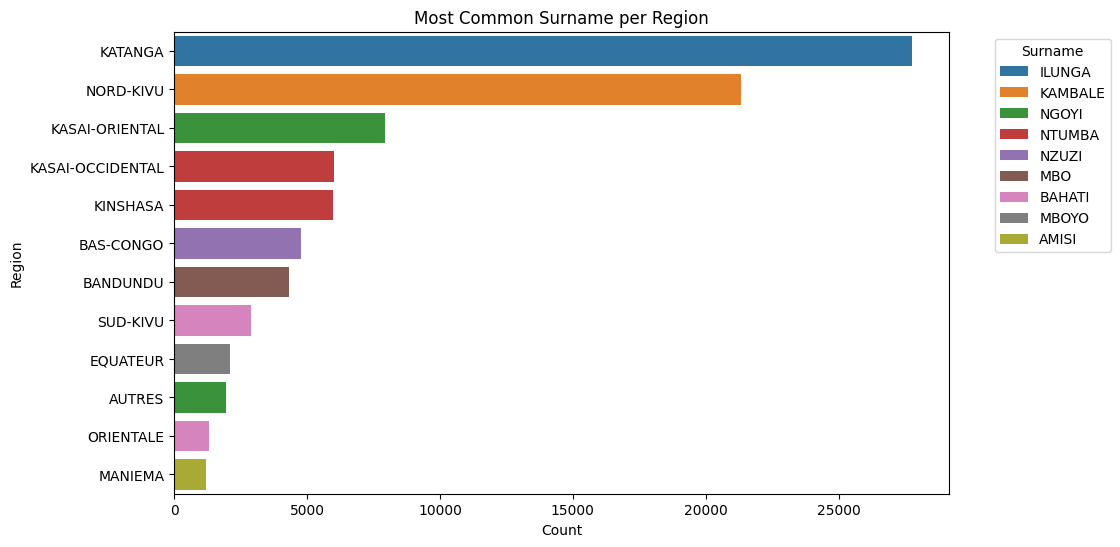

In [51]:
# surnames per region (aggregated)
top_surnames_region = surnames_by_region.sort_values('count', ascending=False).drop_duplicates('province').head(12)
plt.figure(figsize=(10,6))
sns.barplot(y='province', x='count', data=top_surnames_region, hue='surname', dodge=False)
plt.title("Most Common Surname per Region")
plt.xlabel("Count")
plt.ylabel("Region")
plt.legend(title="Surname", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

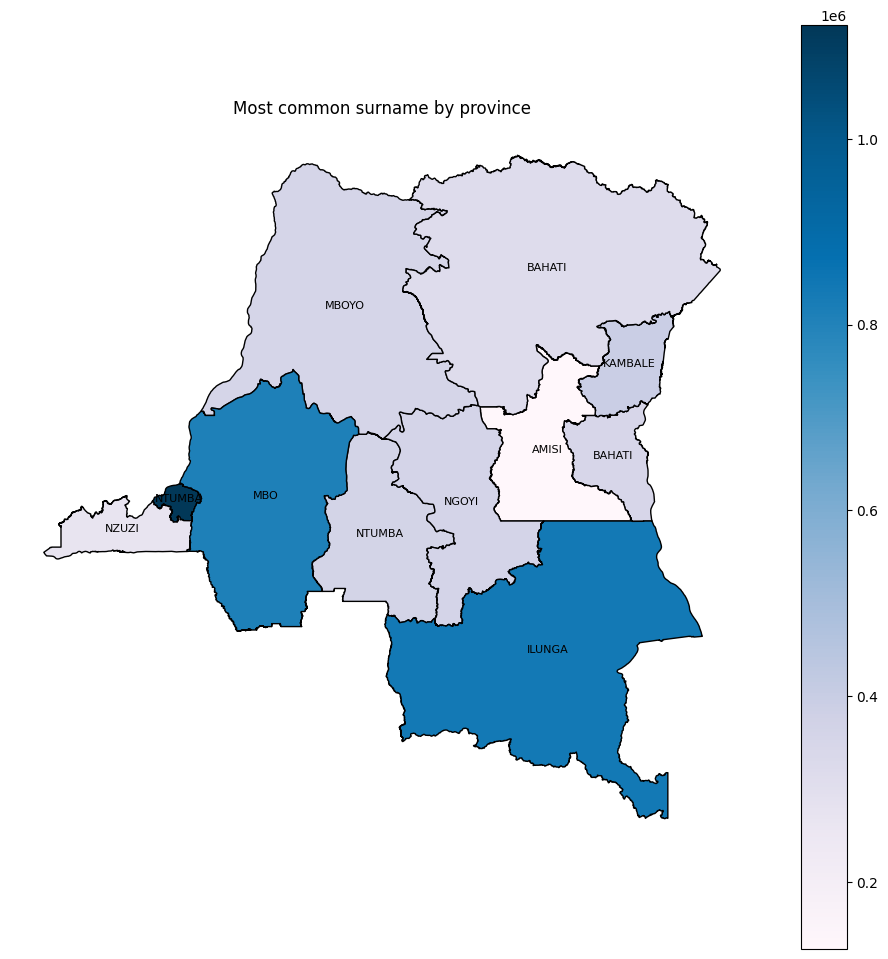

In [52]:
# Map of the most common surname by province in DRC
top_surnames = df_simple.groupby(['province', 'surname'], observed=False).size().reset_index(name='count')
top_surnames = top_surnames.sort_values(['province', 'count'], ascending=[True, False])
top_surnames = top_surnames.drop_duplicates(subset='province', keep='first')
top_surnames['province_clean'] = top_surnames['province'].str.upper().str.strip() \
    .str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')

gdf_named = gdf_merged.merge(top_surnames[['province_clean', 'surname']], 
                             on='province_clean', how='left')

fig, ax = plt.subplots(figsize=(12, 12))
gdf_named.plot(column='count', cmap='PuBu', edgecolor='black', legend=True, ax=ax)

for idx, row in gdf_named.iterrows():
    if pd.notna(row['surname']):
        centroid = row['geometry'].centroid
        plt.text(centroid.x, centroid.y, row['surname'], 
                 horizontalalignment='center', fontsize=8, color='black')

plt.title("Most common surname by province")
plt.axis('off')
plt.show()

In [53]:
# Top 5 surnames by province
top5_surnames = (
    df_simple.groupby(['province_clean', 'surname'], observed=False)
    .size()
    .reset_index(name='count')
    .sort_values(['province_clean', 'count'], ascending=[True, False])
    .groupby('province_clean', group_keys=False)
    .head(5)
)
def make_row(group):
    return pd.Series(
        {f'Name {i+1}': f"{row.surname} ({row.count})"
         for i, row in enumerate(group.itertuples())}
    )

table = top5_surnames.groupby('province_clean', group_keys=False).apply(make_row, include_groups=False).reset_index()
print(table)

      province_clean           Name 1           Name 2            Name 3  \
0             AUTRES     NGOYI (1956)    ILUNGA (1621)      MBUYI (1318)   
1           BANDUNDU       MBO (4336)      MPIA (3030)      MPUTU (2248)   
2          BAS-CONGO     NZUZI (4758)    NLANDU (4071)    MATONDO (3492)   
3           EQUATEUR     MBOYO (2110)    LOKULI (1123)    BOLUMBU (1014)   
4   KASAI-OCCIDENTAL    NTUMBA (6025)     MBUYI (5021)      KANKU (3430)   
5     KASAI-ORIENTAL     NGOYI (7942)    ILUNGA (5241)      MBUYI (4932)   
6            KATANGA   ILUNGA (27775)     NGOY (23185)   KASONGO (16894)   
7           KINSHASA    NTUMBA (5984)    NSIMBA (5625)    MATONDO (5355)   
8            MANIEMA     AMISI (1194)  RAMAZANI (1016)      ASSANI (757)   
9          NORD-KIVU  KAMBALE (21332)   KAVIRA (21194)  KASEREKA (14883)   
10         ORIENTALE    BAHATI (1328)   KAMBALE (1067)     BARAKA (1048)   
11          SUD-KIVU    BAHATI (2886)    FURAHA (2472)    MUGISHO (2331)   

           

In [55]:
# Rare surnames per province (based on TF-IDF, low = rare)
surname_counts = df_simple.groupby(['province_clean', 'surname'], observed=False).size().reset_index(name='count')
province_totals_surname = surname_counts.groupby('province_clean', observed=False)['count'].transform('sum')
surname_counts['tf'] = surname_counts['count'] / province_totals_surname

province_per_surname = surname_counts.groupby('surname', observed=False)['province_clean'].nunique()
surname_counts = surname_counts.merge(province_per_surname.rename('df'), on='surname')

N_surname = surname_counts['province_clean'].nunique()
surname_counts['idf'] = np.log((N_surname + 1) / (surname_counts['df'] + 1)) + 1
surname_counts['tfidf'] = surname_counts['tf'] * surname_counts['idf']
top_rare_surnames = surname_counts.sort_values(['province_clean', 'tfidf'], ascending=[True, True]) \
                                  .groupby('province_clean', observed=False).head(1)

print("Most rare surname per province based on TF-IDF:")
print(top_rare_surnames[['province_clean', 'surname', 'count', 'tfidf']].sort_values(['province_clean']))

Most rare surname per province based on TF-IDF:
          province_clean  surname  count     tfidf
2487              AUTRES   BAKINA      1  0.000006
41315           BANDUNDU  AHONDJU      1  0.000003
103173         BAS-CONGO   ALENGE      1  0.000004
140075          EQUATEUR  AHONDJU      1  0.000003
208411  KASAI-OCCIDENTAL     ABIA      1  0.000004
239974    KASAI-ORIENTAL     ABIA      1  0.000003
266499           KATANGA   ALANGA      1  0.000001
336572          KINSHASA  BISONGA      1  0.000001
454100           MANIEMA     ABIA      1  0.000015
467189         NORD-KIVU    AKASA      1  0.000003
507581         ORIENTALE   BAKINA      1  0.000004
561575          SUD-KIVU  AHONDJU      1  0.000005


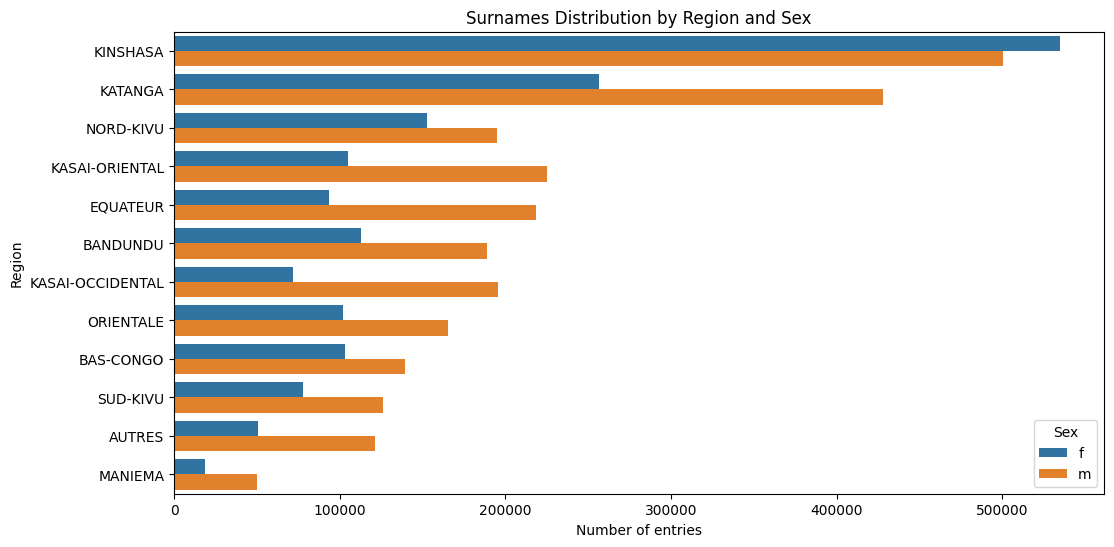

In [56]:
# Bar chart surnames by region and sex
top10_regions = df_simple['province'].value_counts().head(12).index.tolist()
df_top10 = df_simple[df_simple['province'].isin(top10_regions)]
plt.figure(figsize=(12,6))
sns.countplot(data=df_top10, y='province', hue='sex', order=top10_regions)
plt.title("Surnames Distribution by Region and Sex")
plt.xlabel("Number of entries")
plt.ylabel("Region")
plt.legend(title='Sex')
plt.show()

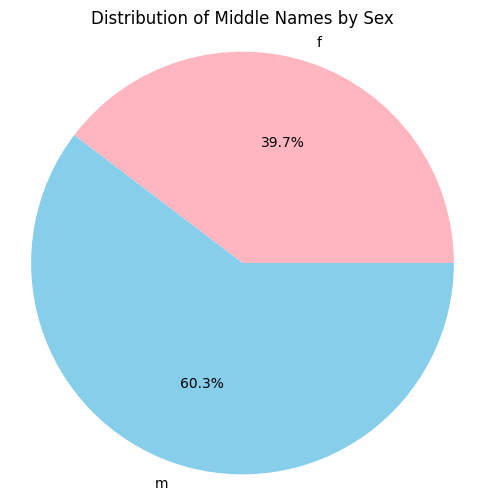

In [57]:
# Pie chart of middle names by sex
middlenames_sex_count = middlenames_by_province_sex.groupby('sex', observed=False)['count'].sum()
plt.figure(figsize=(6,6))
plt.pie(middlenames_sex_count, labels=middlenames_sex_count.index, autopct='%1.1f%%', colors=['lightpink', 'skyblue'])
plt.title("Distribution of Middle Names by Sex")
plt.axis('equal')
plt.show()

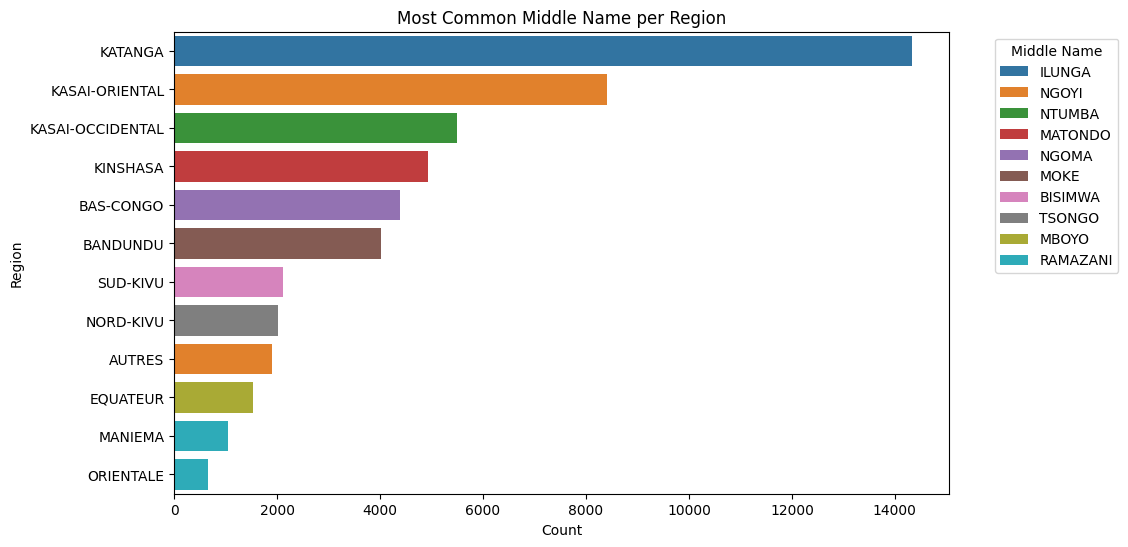

In [58]:
# most popular middle name per region
top_middlename_region = middlenames_by_region.sort_values('count', ascending=False).drop_duplicates('province').head(12)
plt.figure(figsize=(10,6))
sns.barplot(y='province', x='count', data=top_middlename_region, hue='middle_name', dodge=False)
plt.title("Most Common Middle Name per Region")
plt.xlabel("Count")
plt.ylabel("Region")
plt.legend(title="Middle Name", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

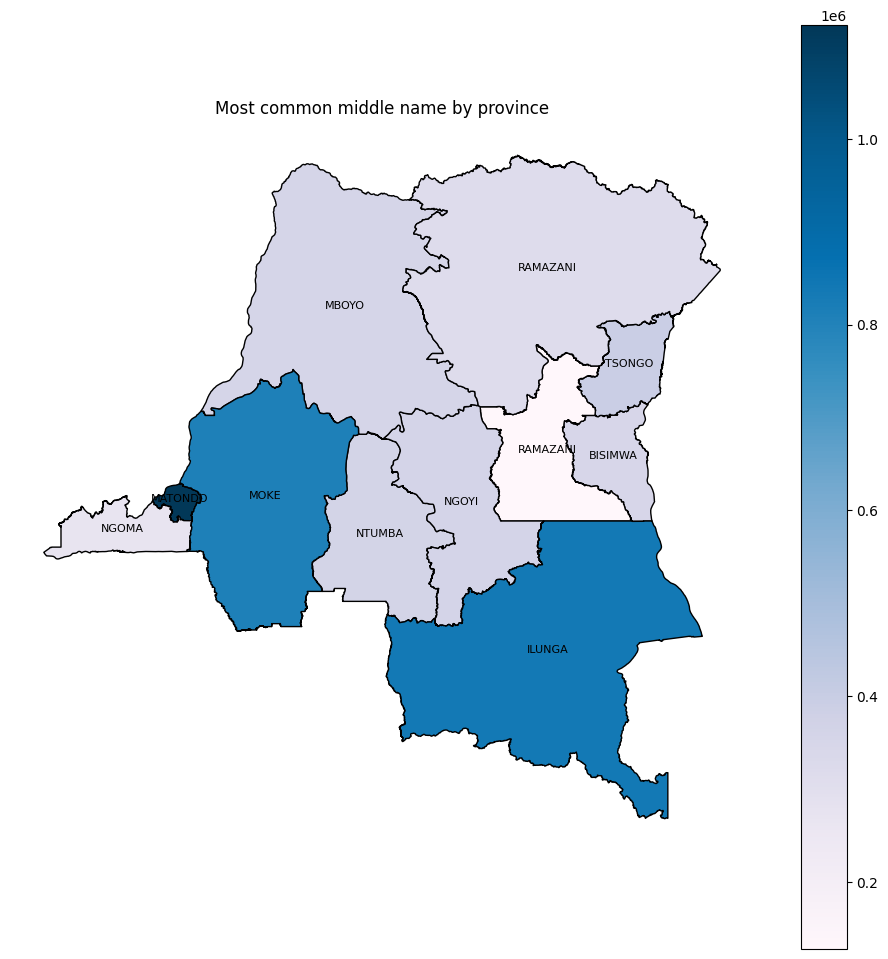

In [59]:
# Map of the most common middle by province in DRC
top_surnames = df_simple.groupby(['province', 'middle_name']).size().reset_index(name='count')
top_surnames = top_surnames.sort_values(['province', 'count'], ascending=[True, False])
top_surnames = top_surnames.drop_duplicates(subset='province', keep='first')
top_surnames['province_clean'] = top_surnames['province'].str.upper().str.strip() \
    .str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')

gdf_named = gdf_merged.merge(top_surnames[['province_clean', 'middle_name']], 
                             on='province_clean', how='left')

fig, ax = plt.subplots(figsize=(12, 12))
gdf_named.plot(column='count', cmap='PuBu', edgecolor='black', legend=True, ax=ax)

for idx, row in gdf_named.iterrows():
    if pd.notna(row['middle_name']):
        centroid = row['geometry'].centroid
        plt.text(centroid.x, centroid.y, row['middle_name'], 
                 horizontalalignment='center', fontsize=8, color='black')

plt.title("Most common middle name by province")
plt.axis('off')
plt.show()

In [60]:
# Top 5 middle names by province
top5_middle_names = (
    df_simple.groupby(['province_clean', 'middle_name'])
    .size()
    .reset_index(name='count')
    .sort_values(['province_clean', 'count'], ascending=[True, False])
    .groupby('province_clean', group_keys=False)
    .head(5)
)
def make_row(group):
    return pd.Series(
        {f'Name {i+1}': f"{row.middle_name} ({row.count})"
         for i, row in enumerate(group.itertuples())}
    )

table = top5_middle_names.groupby('province_clean', group_keys=False).apply(make_row, include_groups=False).reset_index()
print(table)

      province_clean           Name 1         Name 2              Name 3  \
0             AUTRES     NGOYI (1909)  ILUNGA (1736)      KASONGO (1387)   
1           BANDUNDU      MOKE (4024)     MBO (2048)         MPIA (1792)   
2          BAS-CONGO     NGOMA (4387)  NLANDU (2588)       KHONDE (2176)   
3           EQUATEUR     MBOYO (1538)  LOKULI (1343)          NKOY (898)   
4   KASAI-OCCIDENTAL    NTUMBA (5502)  MUAMBA (3463)  NGALAMULUME (2809)   
5     KASAI-ORIENTAL     NGOYI (8403)  ILUNGA (6493)       KAZADI (5415)   
6            KATANGA   ILUNGA (14338)   NGOY (14279)     KASONGO (10702)   
7           KINSHASA   MATONDO (4935)  NTUMBA (4099)       ILUNGA (3993)   
8            MANIEMA  RAMAZANI (1051)    AMISI (778)       SHABANI (649)   
9          NORD-KIVU    TSONGO (2015)  BAHATI (1533)      MAHAMBA (1180)   
10         ORIENTALE   RAMAZANI (663)   BAHATI (576)         YENGA (533)   
11          SUD-KIVU   BISIMWA (2107)  BAHATI (2001)      MIRINDI (1308)   

           

In [61]:
#Rare middle names per province (appear only once)
middle_name_counts = df_simple.groupby(['province_clean', 'middle_name'], observed=False).size().reset_index(name='count')

province_totals = middle_name_counts.groupby('province_clean', observed=False)['count'].transform('sum')
middle_name_counts['tf'] = middle_name_counts['count'] / province_totals

province_per_middlename = middle_name_counts.groupby('middle_name', observed=False)['province_clean'].nunique()
middle_name_counts = middle_name_counts.merge(province_per_middlename.rename('df'), on='middle_name')

N = middle_name_counts['province_clean'].nunique()
middle_name_counts['idf'] = np.log((N + 1) / (middle_name_counts['df'] + 1)) + 1
middle_name_counts['tfidf'] = middle_name_counts['tf'] * middle_name_counts['idf']
top_rare_middlenames = middle_name_counts.sort_values(['province_clean', 'tfidf'], ascending=[True, True]) \
                                  .groupby('province_clean', observed=False).head(1)

print("Most rare middle name per province based on TF-IDF:")
print(top_rare_middlenames[['province_clean', 'middle_name', 'count', 'tfidf']].sort_values(['province_clean']))

Most rare middle name per province based on TF-IDF:
          province_clean middle_name  count     tfidf
4693              AUTRES      BOKOTA      1  0.000006
47004           BANDUNDU       ASANI      1  0.000003
125075         BAS-CONGO      ALONGA      1  0.000004
162069          EQUATEUR     ABRAHAM      1  0.000003
230086  KASAI-OCCIDENTAL     ABRAHAM      1  0.000004
258737    KASAI-ORIENTAL     ABRAHAM      1  0.000003
283510           KATANGA      ALONGA      1  0.000001
384356          KINSHASA      DEBABA      1  0.000001
525057           MANIEMA     BAKENGA      1  0.000015
538841         NORD-KIVU        ANGA      1  0.000003
623578         ORIENTALE     KANANGA      1  0.000004
666765          SUD-KIVU        ANGA      1  0.000005


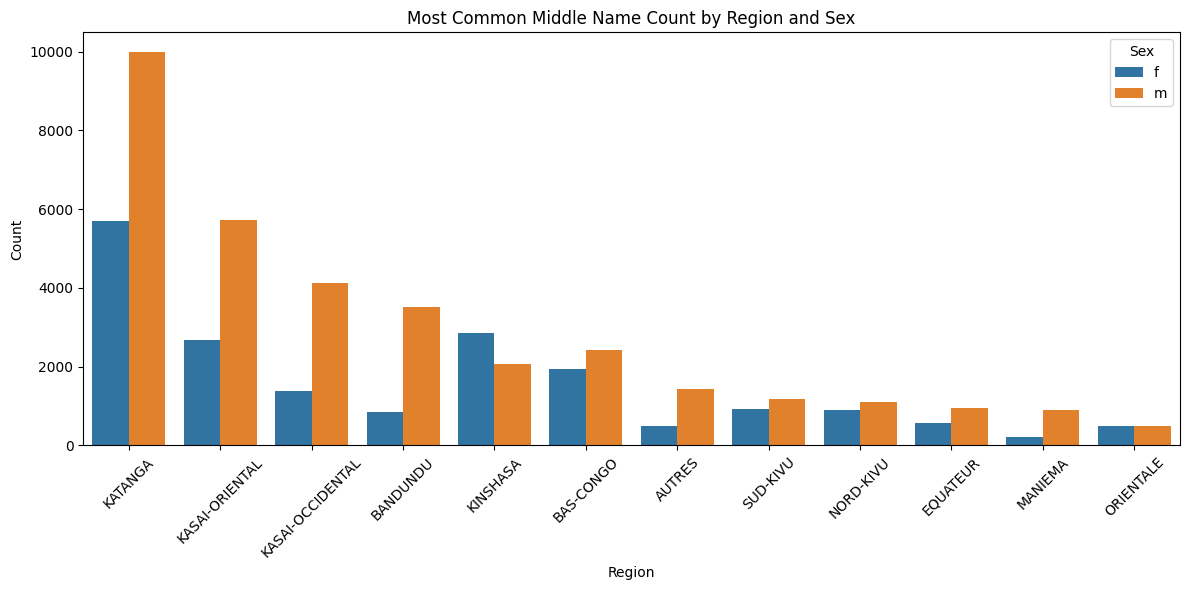

In [62]:
#Bar chart middle name by region and sex
middlenames_by_sex_region = df_simple.groupby(['province', 'sex', 'middle_name'], observed=False).size().reset_index(name='count')
top_middlename_sex_region = middlenames_by_sex_region.sort_values('count', ascending=False).drop_duplicates(['province', 'sex'])

# Bar chart
plt.figure(figsize=(12, 6))
sns.barplot(
    data=top_middlename_sex_region,
    x='province',
    y='count',
    hue='sex'
)
plt.title("Most Common Middle Name Count by Region and Sex")
plt.xlabel("Region")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.legend(title="Sex")
plt.tight_layout()
plt.show()

In [66]:
# Crossover 1: Firstname vs Surname
crossover_firstname_surname = df_simple.groupby(['first_name', 'surname'], observed=False).size().sort_values(ascending=False).head(10)
print("--- Top 10 Firstname vs Surname Crossovers ---")
print(crossover_firstname_surname)
print("\n")

--- Top 10 Firstname vs Surname Crossovers ---
first_name  surname
JEAN        ILUNGA     828
            KASONGO    629
            NGOYI      566
            MBUYI      525
RACHEL      KAVIRA     523
MOISE       KAMBALE    484
JUSTIN      KAMBALE    481
ESTHER      KAVIRA     472
NEEMA       KAVIRA     472
JEAN        NGOY       471
dtype: int64




In [67]:
# Crossover: Firstname vs Surname vs Sex
crossover_fname_sname_sex = (
    df_simple.value_counts(['sex', 'first_name', 'surname'])
    .reset_index(name='count')
    .sort_values('count', ascending=False)
    .head(10)
)

print("--- Top 10 Firstname vs Surname Crossovers by Sex ---")
for sex, group in crossover_fname_sname_sex.groupby('sex', observed=False):
    print(f"\nSEX: {sex}")
    for _, row in group.iterrows():
        print(f"  {row['first_name']} {row['surname']} — {row['count']}")


--- Top 10 Firstname vs Surname Crossovers by Sex ---

SEX: f
  RACHEL KAVIRA — 520
  NEEMA KAVIRA — 472
  ESTHER KAVIRA — 470

SEX: m
  JEAN ILUNGA — 827
  JEAN KASONGO — 627
  JEAN NGOYI — 566
  JEAN MBUYI — 525
  MOISE KAMBALE — 483
  JUSTIN KAMBALE — 481
  JEAN NTUMBA — 470


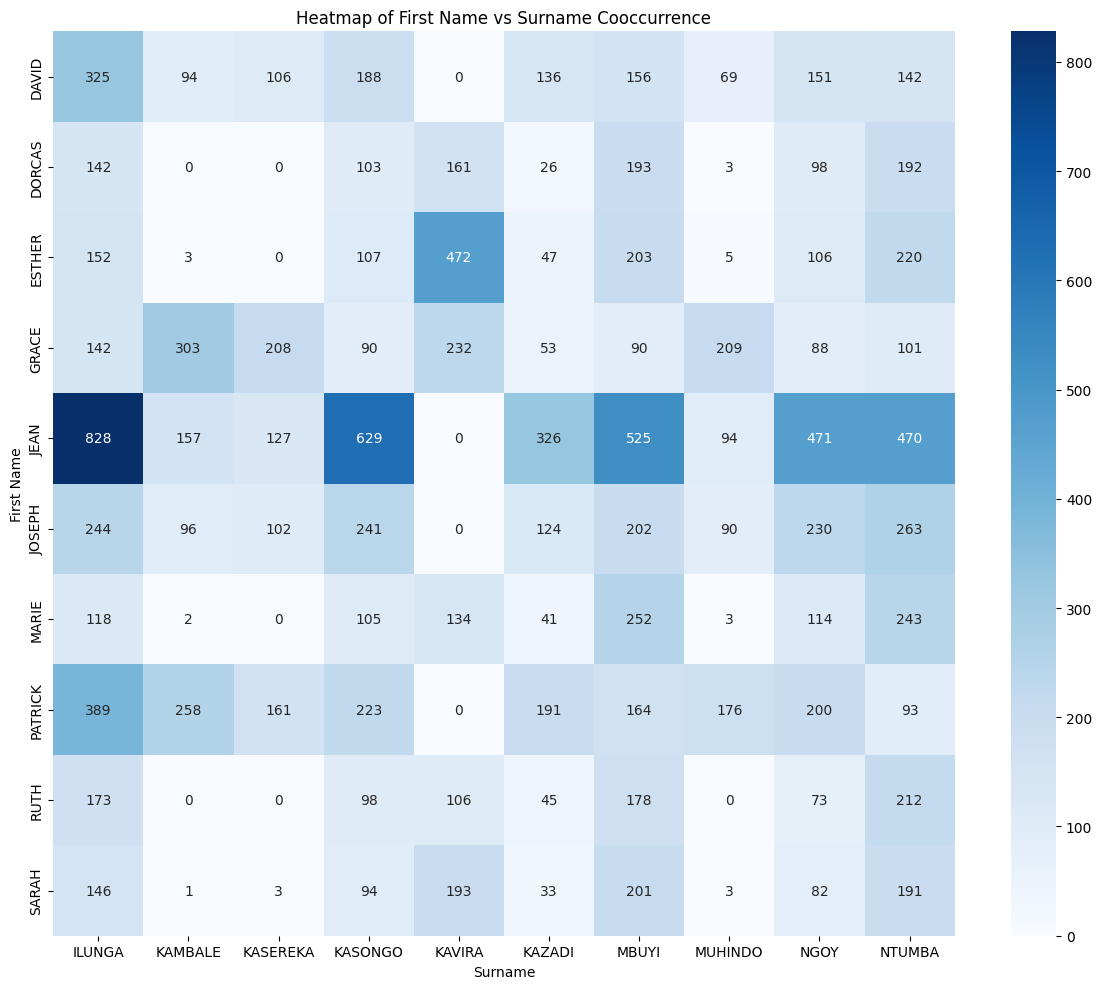

In [68]:
# frequency of joint appearance
top_firstnames = df_simple['first_name'].value_counts().head(10).index
top_surnames = df_simple['surname'].value_counts().head(10).index

filtered_df = df_simple[
    df_simple['first_name'].isin(top_firstnames) &
    df_simple['surname'].isin(top_surnames)
]

cooccurrence = filtered_df.groupby(['first_name', 'surname'], observed=False).size().unstack(fill_value=0)

#heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(cooccurrence, annot=True, fmt='d', cmap='Blues')
plt.title('Heatmap of First Name vs Surname Cooccurrence')
plt.xlabel('Surname')
plt.ylabel('First Name')
plt.tight_layout()
plt.show()

In [69]:
# Crossover 2: Firstname vs Middle Name
crossover_firstname_middlename = df_simple.groupby(['first_name', 'middle_name'], observed=False).size().sort_values(ascending=False).head(10)
print("--- Top 10 Firstname vs Middle Name Crossovers ---")
print(crossover_firstname_middlename)
print("\n")

--- Top 10 Firstname vs Middle Name Crossovers ---
first_name  middle_name
JEAN        ILUNGA         555
            NGOYI          494
            KASONGO        466
ILUNGA      WA             443
JEAN        NTUMBA         432
PIERRE      JEAN           413
NGOY        NGOY           412
JEAN        MUTOMBO        381
PAUL        JEAN           378
JEAN        KAZADI         366
dtype: int64




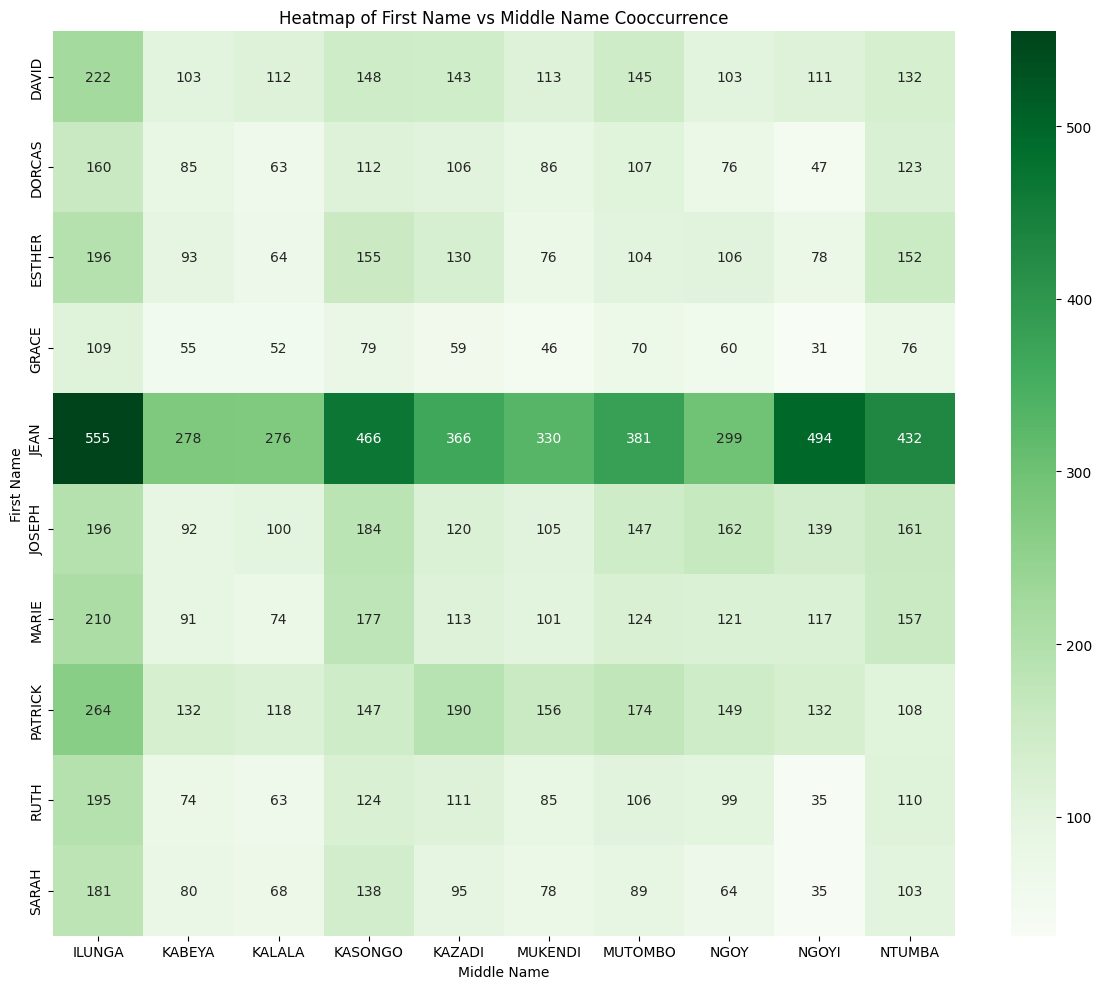

In [70]:
# frequency of joint appearance
top_middlenames = df_simple['middle_name'].value_counts().head(10).index

filtered_df = df_simple[
    df_simple['first_name'].isin(top_firstnames) &
    df_simple['middle_name'].isin(top_middlenames)
]

cooccurrence = filtered_df.groupby(['first_name', 'middle_name'], observed=False).size().unstack(fill_value=0)

plt.figure(figsize=(12, 10))
sns.heatmap(cooccurrence, annot=True, fmt='d', cmap='Greens')
plt.title('Heatmap of First Name vs Middle Name Cooccurrence')
plt.xlabel('Middle Name')
plt.ylabel('First Name')
plt.tight_layout()
plt.show()

In [72]:
# Crossover: Firstname vs Middle Name vs Sex
crossover_fname_middlename_sex = (
    df_simple
    .groupby(['sex', 'first_name', 'middle_name'], observed=True)
    .size()
    .reset_index(name='count')
    .sort_values('count', ascending=False)
    .head(10)
)

print("--- Top 10 Firstname vs Middle Name Crossovers by Sex ---")
for sex, group in crossover_fname_middlename_sex.groupby('sex', observed=True):
    print(f"\nSEX: {sex}")
    for _, row in group.iterrows():
        print(f"  {row['first_name']} {row['middle_name']} — {row['count']}")

--- Top 10 Firstname vs Middle Name Crossovers by Sex ---

SEX: f
  SARAH SARAH — 364

SEX: m
  JEAN ILUNGA — 553
  JEAN NGOYI — 494
  JEAN KASONGO — 465
  JEAN NTUMBA — 428
  PIERRE JEAN — 407
  JEAN MUTOMBO — 381
  PAUL JEAN — 375
  JEAN KAZADI — 366
  JEAN MUKENDI — 329


In [73]:
# Crossover 3: Surname vs Middle Name
print("--- Top 10 Surname vs Middle Name Crossovers ---")
crossover_surname_middlename = df_simple.groupby(['surname', 'middle_name'], observed=True).size().sort_values(ascending=False).head(10)
print(crossover_surname_middlename)
print("\n")

--- Top 10 Surname vs Middle Name Crossovers ---
surname  middle_name
ILUNGA   ILUNGA         1320
         NGOY           1160
KABANGE  NUMBI          1005
NGOYI    NGOYI           972
NGOY     MWILAMBWE       861
KAZADI   KAZADI          794
ILUNGA   KASONGO         782
KASONGO  ILUNGA          730
NTUMBA   NTUMBA          703
MUTOMBO  MUTOMBO         691
dtype: int64




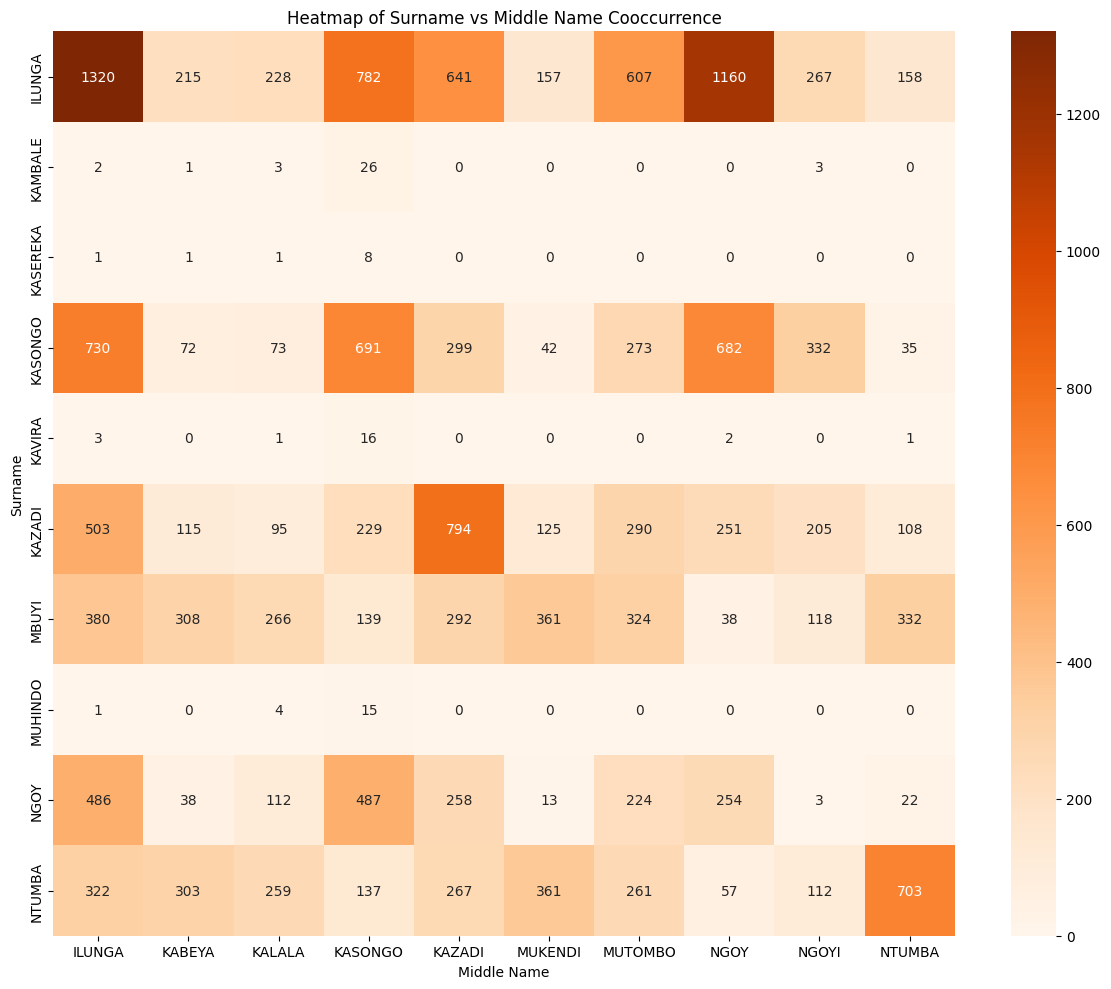

In [74]:
# frequency of joint appearance
top_surnames = df_simple['surname'].value_counts().head(10).index 
top_middlenames = df_simple['middle_name'].value_counts().head(10).index
filtered_df = df_simple[
    df_simple['surname'].isin(top_surnames) &
    df_simple['middle_name'].isin(top_middlenames)
]

cooccurrence = filtered_df.groupby(['surname', 'middle_name']).size().unstack(fill_value=0)

plt.figure(figsize=(12, 10))
sns.heatmap(cooccurrence, annot=True, fmt='d', cmap='Oranges')
plt.title('Heatmap of Surname vs Middle Name Cooccurrence')
plt.xlabel('Middle Name')
plt.ylabel('Surname')
plt.tight_layout()
plt.show()

In [75]:
# Crossover: Surname vs Middle Name vs Sex
crossover_surname_middlename_sex = df_simple.groupby(['sex', 'surname', 'middle_name'], observed=True).size().reset_index(name='count')
crossover_surname_middlename_sex = crossover_surname_middlename_sex.sort_values('count', ascending=False).head(10)

print("--- Top 10 Surname vs Middle Name Crossovers by Sex ---")
for sex, group in crossover_surname_middlename_sex.groupby('sex', observed=True):
    print(f"\nSEX: {sex}")
    for _, row in group.iterrows():
        print(f"  {row['surname']} {row['middle_name']} — {row['count']}")

--- Top 10 Surname vs Middle Name Crossovers by Sex ---

SEX: m
  ILUNGA ILUNGA — 1228
  NGOYI NGOYI — 803
  KAZADI KAZADI — 747
  ILUNGA NGOY — 703
  KABANGE NUMBI — 701
  MUTOMBO MUTOMBO — 662
  NGOY MWILAMBWE — 639
  MUKENDI MUKENDI — 610
  KASONGO KASONGO — 597
  KABEYA KABEYA — 582


In [ ]:
# Calculate the length of first names, surnames, and middle names
df['firstname_length'] = df_simple['first_name'].str.len()
df['surname_length'] = df_simple['surname'].str.len()
df['middlename_length'] = df_simple['middle_name'].str.len()

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Histogram for firstname length
sns.histplot(df['firstname_length'], kde=True, ax=axes[0], color='skyblue')
axes[0].set_title('Distribution of First Name Length')
axes[0].set_xlabel('Number of Letters')
axes[0].set_ylabel('Frequency')

# Histogram for surname length
sns.histplot(df['surname_length'], kde=True, ax=axes[1], color='lightgreen')
axes[1].set_title('Distribution of Surname Length')
axes[1].set_xlabel('Number of Letters')
axes[1].set_ylabel('Frequency')

# Histogram for middle name length
sns.histplot(df['middlename_length'], kde=True, ax=axes[2], color='salmon')
axes[2].set_title('Distribution of Middle Name Length')
axes[2].set_xlabel('Number of Letters')
axes[2].set_ylabel('Frequency')

plt.tight_layout()
plt.show()